# Kronecker Products vs Nyström Style Approximation

## Problem Setup: Kronecker-Structured Weight Matrix
In an *unsquared* probabilistic circuit the `TorchSumLayer` is parameterised by a weight matrix
$\mathbf{W}_{\text{base}} \in \mathbb{R}^{K_o \times K_i}.$ Where, $K_o$ is the number of outputs to the sum layer and $K_i$ is the number of inputs in the input layer.

Applying the **squaring operator** (Loconte et al., 2024) duplicates the mixture and multiplies the two copies element‑wise.  At the level of a single sum layer this is equivalent to replacing the original weight matrix by the Kronecker product of the matrix with **itself**:

$\boxed{\mathbf{W}_{} = \mathbf{W}_{\text{base}} \,\otimes\, \mathbf{W}_{\text{base}} \in \mathbb{R}^{K_o^2 \times K_i^2}}.$

Hence the two factor matrices are identical:
$\mathbf{A}=\mathbf{B}=\mathbf{W}_{\text{base}}.$

* **Input dimension.**  Each original input unit now participates in every ordered pair, giving \$K\_i^2\$ inputs.
* **Output dimension.**  Each original sum unit is paired with every other, giving \$K\_o^2\$ outputs.
* **Arity.**  If the unsquared layer had arity \$H\$, the squared layer has arity \$2H\$ because the two identical branches are concatenated.

The result is a *subtractive mixture*: negative weights are permitted in \$\mathbf{W}\_{\text{base}}\$, yet the overall network remains non‑negative because probabilities are squared at the root (see Loconte et al., 2024).

---
## Nyström Approximation Framework

Following Nemtsov, Averbuch & Schclar (2016), we extend the classical Nyström method from symmetric matrices to arbitrary rectangular matrices by operating in the singular-value domain. For the weight matrix $\mathbf{W} \in \mathbb{R}^{K_o \times K_i}$, we partition:

$\mathbf{W} = \begin{bmatrix} \mathbf{A}_W & \mathbf{B}_W\\ \mathbf{F}_W & \mathbf{C}_W \end{bmatrix}$

where:
- $\mathbf{A}_W \in \mathbb{R}^{s \times s}$ is the pivot block (top-left corner)
- $\mathbf{B}_W \in \mathbb{R}^{s \times (K_i-s)}$ contains the remaining top rows
- $\mathbf{F}_W \in \mathbb{R}^{(K_o-s) \times s}$ contains the remaining left columns
- $\mathbf{C}_W \in \mathbb{R}^{(K_o-s) \times (K_i-s)}$ is the out-of-sample block

### Step 1: Pivot-Block SVD
Compute the rank-$s$ singular value decomposition of the pivot block:
$$\mathbf{A}_W = \mathbf{U}\boldsymbol{\Lambda}\mathbf{H}^{\top}$$
where $\mathbf{U}, \mathbf{H} \in \mathbb{R}^{s \times s}$ are unitary matrices and $\boldsymbol{\Lambda} = \text{diag}(\lambda_1, \ldots, \lambda_s)$ with $\lambda_i > 0$.

### Step 2: Extending Singular Vectors
Extend the left singular vectors:
$\tilde{\mathbf{U}} = \mathbf{F}_W \mathbf{H} \boldsymbol{\Lambda}^{-1} \in \mathbb{R}^{(K_o-s) \times s}$

Extend the right singular vectors:
$\tilde{\mathbf{H}} = \boldsymbol{\Lambda}^{-1} \mathbf{U}^{\top} \mathbf{B}_W \in \mathbb{R}^{(K_i-s) \times s}$

### Step 3: Assembling the Nyström Approximation
Construct the extended matrices:
$$\hat{\mathbf{U}} = \begin{bmatrix} \mathbf{U}\\ \tilde{\mathbf{U}} \end{bmatrix}, \quad \hat{\mathbf{H}} = \begin{bmatrix} \mathbf{H}\\ \tilde{\mathbf{H}} \end{bmatrix}$$

The Nyström approximation becomes:
$$\boxed{\hat{\mathbf{W}} = \begin{bmatrix} \mathbf{A}_W & \mathbf{B}_W\\ \mathbf{F}_W & \mathbf{F}_W \mathbf{A}_W^{+} \mathbf{B}_W \end{bmatrix}}$$

where $\mathbf{A}_W^{+}$ is the Moore–Penrose pseudo-inverse. This can be written compactly as:
$$\hat{\mathbf{W}} = \begin{bmatrix} \mathbf{A}_W\\ \mathbf{F}_W \end{bmatrix} \mathbf{A}_W^{+} \begin{bmatrix} \mathbf{A}_W & \mathbf{B}_W \end{bmatrix}$$

## Low-Rank Factorization for Efficient Computation

The Nyström approximation yields a natural low-rank factorization:
$\hat{\mathbf{W}} = \mathbf{U}_{lr} \mathbf{V}_{lr}^T$

where:
- $\mathbf{U}_{lr} = \begin{bmatrix} \mathbf{A}_W\\ \mathbf{F}_W \end{bmatrix} \in \mathbb{R}^{K_o \times s}$
- $\mathbf{V}_{lr} = \begin{bmatrix} \mathbf{A}_W & \mathbf{B}_W \end{bmatrix} (\mathbf{A}_W^{+})^T \in \mathbb{R}^{K_i \times s}$

## Forward Pass Implementation

The core computation in `TorchSumLayer.forward()`:
$\mathbf{Y} = \mathbf{X} \hat{\mathbf{W}}^T = \mathbf{X} \mathbf{V}_{lr} \mathbf{U}_{lr}^T$

is efficiently computed in two stages:
1. $\mathbf{Z} = \mathbf{X} \mathbf{V}_{lr} \in \mathbb{R}^{FB \times s}$
2. $\mathbf{Y} = \mathbf{Z} \mathbf{U}_{lr}^T \in \mathbb{R}^{FB \times K_o}$

where $FB$ is the batch size.

## Computational Benefits

### Memory Reduction
The approximation reduces storage from $\mathcal{O}(K_o \cdot K_i)$ to $\mathcal{O}(s \cdot (K_o + K_i))$:
$\text{Memory Ratio} = \frac{s \cdot (K_o + K_i)}{K_o \cdot K_i}$

### Computational Speedup  
FLOPs reduce from $\mathcal{O}(FB \cdot K_o \cdot K_i)$ to $\mathcal{O}(FB \cdot s \cdot K_i) + \mathcal{O}(FB \cdot s \cdot K_o)$:
$\text{FLOP Ratio} = \frac{s \cdot K_i + s \cdot K_o}{K_o \cdot K_i} = \frac{s \cdot (K_i + K_o)}{K_o \cdot K_i}$

For $s \ll \min(K_o, K_i)$, this provides significant computational savings while preserving the essential spectral structure of the Kronecker-product weight matrix $\mathbf{W} = \mathbf{A} \otimes \mathbf{B}$.


### 2&nbsp;&nbsp;`TorchKroneckerParameter.forward` preserves tensor semantics 

The previous cell constructs a learnable Kronecker module, moves **all** parameters to the chosen
device, performs a forward pass, and prints metadata.  
The `assert`s demonstrate that:

* Inputs and output are of type `torch.Tensor`.
* No hidden CPU–GPU transfers are introduced.


In [1]:

import torch
from cirkit.backend.torch.parameters.nodes import TorchKroneckerParameter

# 1 Pick the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

# 2 Create the parameterisation module
p = TorchKroneckerParameter(
    in_shape1=(2, 3),
    in_shape2=(3, 2),
    num_folds=4,
).to(device)

# 3 Generate inputs
x1 = torch.randn(4, 2, 3, device=device)
x2 = torch.randn(4, 3, 2, device=device)

# 4 Forward pass
y = p.forward(x1, x2)

# 5 Inspect shapes, devices and dtypes
def info(label, t):
    print(f"{label}: shape={tuple(t.shape)}, device={t.device}, dtype={t.dtype}")

info("x1", x1)
info("x2", x2)
info("y ", y)

# Lightweight proof of tensor properties
assert x1.device == y.device == x2.device
assert x1.dtype  == y.dtype  == x2.dtype


Using cuda
x1: shape=(4, 2, 3), device=cuda:0, dtype=torch.float32
x2: shape=(4, 3, 2), device=cuda:0, dtype=torch.float32
y : shape=(4, 6, 6), device=cuda:0, dtype=torch.float32


### Construct a Demo Squared Circuit

In [2]:
import cirkit.symbolic.functional as SF
from cirkit.symbolic.io import plot_circuit
from helpers import define_circuit_one_sum
NUM_INPUT_UNITS = 50
NUM_SUM_UNITS   = 50

net = define_circuit_one_sum(NUM_INPUT_UNITS, NUM_SUM_UNITS)

from cirkit.pipeline import PipelineContext
ctx = PipelineContext(backend="torch", semiring="sum-product",
                      fold=False, optimize=False)
cc = ctx.compile(net).cpu().eval()

print("Structural properties:")
print(f"  - Smoothness:              {net.is_smooth}")
print(f"  - Decomposability:         {net.is_decomposable}")
print(f"  - Structured‑decomposable: {net.is_structured_decomposable}")

# Construct the circuit computing Z, i.e., the integral of |c(X)|^2 over the complete domain of X
symbolic_circuit_partition_func = SF.multiply(net, net)
plot_circuit(symbolic_circuit_partition_func)
csc = ctx.compile(symbolic_circuit_partition_func)
kronparameter = csc.layers[1].weight._nodes[4]
print(kronparameter)

Structural properties:
  - Smoothness:              True
  - Decomposability:         True
  - Structured‑decomposable: True
TorchKroneckerParameter(
  input-shapes: [(1, 50, 50), (1, 50, 50)]
  output-shape: (1, 2500, 2500)
)


### Conditions for an accurate Nyström approximation (even for rectangular matrices)
 <font color='red'>Note that **NO** analysis on the structure of these matrices during and after training is conducted here</font>

> **Nemtsov, A.; Averbuch, A.; Schclar, A.**  
> *Matrix Compression using the Nyström Method* (Intelligent Data Analysis 20 (5), 2016) [[DOI:10.3233/IDA-160854](https://doi.org/10.3233/IDA-160854)]   
> “Experiments have been performed on real-world kernels and random general matrices. These show that the algorithm performs well **when the spectrum of the matrix decays quickly** and **the sample is sufficiently large** to capture most of the energy of the matrix … Another experiment showed that the **non-singularity of the sample matrix** (as measured by the magnitude of the smallest singular value) is **exponentially inversely related to the approximation error**.”  

**Why these three checks matter (square *and* rectangular versions)**  

| Diagnostic | What to look for | Why it matters for Nyström |
|------------|-----------------|----------------------------|
| **Fast spectral decay** | Clear elbow / steep drop in the scree plot; low effective rank *$K_{eff}$*. | Nyström only needs to reconstruct the leading sub-space; a short tail keeps the approximation error small. |
| **Sample size ≥ *$K_{eff}$*** | Sketch (number of sampled cols/rows) at least as large as *$K_{eff}$*. | Ensures the sketch spans the dominant directions that carry ≥ 95 % of the energy. |
| **Non-singular sketch** | Smallest singular value σ_min of the sketch not near zero. | A well-conditioned pseudo-inverse keeps the reconstruction stable; empirically the error decays ∝ exp(−σ_min). |

Generalised Nyström algorithms for **non-square matrices** satisfy the *same* error bounds and therefore rely on the same three conditions (see Nakatsukasa 2020 §1 for a modern analysis).

> ✅ If your tensor passes all three tests, you can confidently apply the (generalised) Nyström method for a fast, accurate low-rank approximation.


torch.Size([2500, 2500])


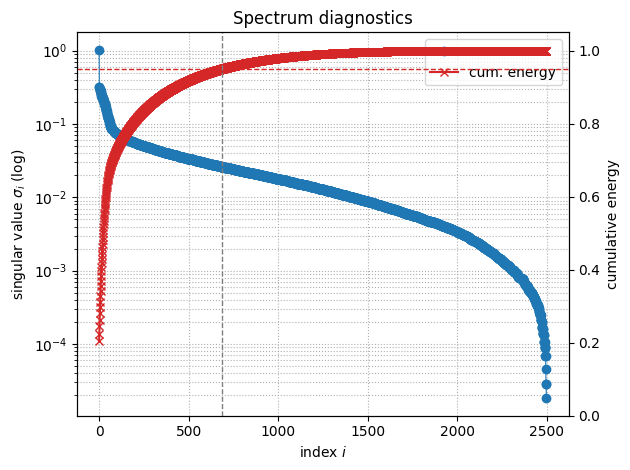

effective rank k_eff = 687


In [3]:
import torch
from helpers import spectrum_diagnostics
# extract the weight tensor from the squared circuit torch sum layer
with torch.no_grad():
    K = csc.layers[1].weight().squeeze().clone() 
    print(K.shape)
# spectrum diagnostics
k_eff = spectrum_diagnostics(K, energy_thresh=0.95)
print(f"effective rank k_eff = {k_eff}")



### 3&nbsp;&nbsp;A minimal Nyström helper

`nystrom_approximation` relies on the **batched** `torch.linalg.pinv` (available since PyTorch 1.9)
and produces a rank‑`d` symmetric positive‑semidefinite matrix.

For large \(D\) and modest \(d\ll D\) we reduce

* **Compute** from $\mathcal{O}(D^3)$ to $\mathcal{O}(d^2D)$.
* **Memory** from $\mathcal{O}(D^2)$ to $\mathcal{O}(dD)$.


### GPU Nystrom Implementation

In [4]:
import torch
from typing import Union, Sequence

def nystrom_approximation_general_gpu(
    M: torch.Tensor,
    idx: Union[torch.Tensor, Sequence[int]]
) -> torch.Tensor:
    """
    Nyström approximation of a general (possibly rectangular) matrix M
    using a *specified* set of pivot indices.

    Parameters
    ----------
    M   : (m, n) tensor
          Dense matrix (need not be square nor symmetric).
    idx : 1-D tensor or sequence of int, length s
          Indices (0-based) that select both the pivot *rows* and *columns*.
          These will form the s × s core block A_M.

    Returns
    -------
    torch.Tensor
        Nyström approximation \\hat M of shape (m, n):

            \\hat M = \\begin{bmatrix}
                           A_M & B_M \\\\
                           F_M & F_M A_M^{+} B_M
                       \\end{bmatrix} ,

        where the blocks are defined by the chosen indices and
        A_M^{+} is the Moore–Penrose pseudo-inverse of A_M.
    """
    with torch.no_grad():
        # --- validate & coerce -------------------------------------------------
        idx = torch.as_tensor(idx, dtype=torch.long, device=M.device)
        if idx.ndim != 1:
            raise ValueError("`idx` must be a 1-D vector of indices.")
        m, n = M.shape
        s = idx.numel()
        if s == 0:
            raise ValueError("`idx` cannot be empty.")
        if torch.any(idx < 0) or torch.any(idx >= m) or torch.any(idx >= n):
            raise IndexError("some indices lie outside the matrix dimensions.")
        if s >= min(m, n):
            return M        # nothing to approximate; keep original
    
        # --- complementary index views (no large allocations) -----------------
        mask_r = torch.ones(m, dtype=torch.bool, device=M.device)
        mask_c = torch.ones(n, dtype=torch.bool, device=M.device)
        mask_r[idx] = False
        mask_c[idx] = False
        comp_r = torch.nonzero(mask_r, as_tuple=False).squeeze(1)
        comp_c = torch.nonzero(mask_c, as_tuple=False).squeeze(1)
    
        # --- tiny pivot block & pseudo-inverse --------------------------------
        A = M[idx.unsqueeze(1), idx]                 # (s, s)   view
        A_pinv = torch.linalg.pinv(A)                # (s, s)   new (small)
    
        # --- top-right slice B (view) + intermediate K = A⁺ B -----------------
        B  = M[idx.unsqueeze(1), comp_c]             # (s, n-s) view
        K  = A_pinv @ B                              # (s, n-s) temp ❶
    
        # --- bottom-left slice F (view) ---------------------------------------
        F = M[comp_r.unsqueeze(1), idx]              # (m-s, s) view
    
        # --- bottom-right block: F K  (single GEMM) ---------------------------
        M[comp_r.unsqueeze(1), comp_c] = F @ K       # result written
    
        # --- top-left block A was already correct, but make sure contiguous --- 
        # (optional; remove if you don’t care about non-contiguous strides)
        # M[idx.unsqueeze(1), idx] = A               # identical values
    
        # --- remaining two off-diagonal blocks need writing -------------------
        M[idx.unsqueeze(1), comp_c]  = B             # top-right
        M[comp_r.unsqueeze(1), idx]  = F             # bottom-left


    return M


In [5]:
import torch
from helpers import nystrom_approximation_general_unopt
K = csc.layers[1].weight().squeeze().clone() 
# --- Choose landmark indices ----------------------------------------------
# Must be valid for BOTH rows and columns; here we take 3 landmarks.
pivot_idx = [0, 3]                   
K_cpu = K.clone().detach().to("cpu", non_blocking=True)
# --- Nyström approximation -------------------------------------------------
K_hat = nystrom_approximation_general_unopt(K, pivot_idx)
K_GPU = nystrom_approximation_general_gpu(K,pivot_idx)
# --- Checks ----------------------------------------------------------------
print("Original shape :", K.shape)
print("Approx shape   :", K_hat.shape)
print("Fro-norm error :", (K_cpu - K_GPU).norm().item())
# print(K_cpu)
# print("-------")
# print(K_hat)
# # Boolean matrix: True where entries differ (within a tolerance)
# diff_mask = torch.isclose(K, K_hat, atol=1e-2, rtol=1e-2)


Original shape : torch.Size([2500, 2500])
Approx shape   : torch.Size([2500, 2500])
Fro-norm error : 5.074024677276611


## Experiments: Measuring Efficiency of Low-Rank Approximations}

We begin by evaluating the computational benefits of replacing full Kronecker product matrices with low-rank approximations in probabilistic circuit inference.

Our baseline implementation relies on the $\texttt{TorchKroneckerParameter}$ module in the Cirkit model, which internally uses $\texttt{torch.kron}$ to represent high-dimensional Kronecker-structured weight matrices. We compare this with a modified version outlined at the start of the notebook. The following experiments are conducted:


**Experiment 1: Compute Efficiency (FLOPs and Time).**



We measure the number of floating-point operations (FLOPs) and wall-clock time required to perform inference with the full Kronecker product versus its low-rank approximation. These metrics allow us to assess whether the theoretical complexity reduction from $\mathcal{O}(n^d)$ to $\mathcal{O}(drn)$ (assuming $r \ll n$) translates into practical runtime improvements. FLOP counts and timing are recorded for varying matrix dimensions and approximation ranks.



**Experiment 2: Memory Usage.**



We measure peak memory consumption during inference to evaluate whether the low-rank parameterization provides practical memory savings. Since \texttt{torch.kron} in the baseline implicitly materializes large intermediate tensors, we expect the low-rank form—which avoids explicitly storing the full Kronecker product—to yield significant reductions in memory footprint. We track both CPU and GPU memory usage where applicable.

These experiments establish a foundational performance comparison between the full Kronecker baseline and its low-rank approximation. In future work, we will extend this comparison to additional structured approximation methods, including tensor decompositions and randomized low-rank projection techniques.



## 4&nbsp;&nbsp;Benchmarks (to be completed)

Benchmarks:

1. Peak Memory Usage
2. FLOPS
3. Inference Time (.forward)
4. Report relative Frobenius‑norm errors.




Variables being changed:
1. Size of K (matrix we are approximating)
2. Size of subsample (pivot_idx)
3. Method of generating pivot_idx (Later date)

| size \(K\) | rank \(len(pivot_idx)\) | **cirkit-kron** time (ms) | **cirkit-kron** memory (MB) | **cirkit-kron** FLOPS |  **nys** time (ms) | **nys** memory (MB) |**nys** FLOPS | rel. error |
|-----------:|-----------:|-------------------:|---------------------:|------------------:|------------------:|------------------:|---------------------:|-----------:|
|   |   |   |   |   |   |   |


### TorchKroneckerParameter Instantiation function

In [6]:
import cirkit.symbolic.functional as SF
from cirkit.symbolic.io import plot_circuit
from cirkit.pipeline import PipelineContext
from helpers import define_circuit_one_sum

def build_and_compile_circuit(input_units: int, sum_units: int):
    """
    Build a one‐sum circuit with the given number of input and sum units,
    compile it in a sum‐product semiring, and return only the compiled circuit.
    All intermediate variables are deleted before returning.
    """
    # Build symbolic network
    net = define_circuit_one_sum(input_units, sum_units)

    # Compile network to a torch backend
    ctx = PipelineContext(
        backend="torch",
        semiring="sum-product",
        fold=False,
        optimize=False
    )
    cc = ctx.compile(net).cpu().eval()

    # Build and plot the partition‐function circuit
    symbolic_circuit_partition_func = SF.multiply(net, net)
    plot_circuit(symbolic_circuit_partition_func)

    # Compile the partition function circuit
    csc = ctx.compile(symbolic_circuit_partition_func)

    # (Optional) inspect a particular parameter
    kronparameter = csc.layers[1].weight._nodes[4]

    # Delete everything except the result
    del net, cc, ctx, symbolic_circuit_partition_func, kronparameter
    return csc


### Low Rank Approximation build

### Benchmark 1: Peak Memory Usage

In [7]:
import copy 
csc = build_and_compile_circuit(40,20)
csc2=copy.deepcopy(csc)
print(csc.layers[1].weight().shape)

torch.Size([1, 400, 1600])


In [8]:
# --- 1. Imports --------------------------------------------------------------
import torch.nn as nn
from cirkit.backend.torch.layers.inner import TorchSumLayer        # the baseline
from nystromlayer import NystromSumLayer                           # your wrapper

# --- 2. Recursive graph-walk -------------------------------------------------
def replace_sum_layers(module: nn.Module, *, rank: int) -> None:
    """
    Walk `module` and in-place replace every TorchSumLayer with NystromSumLayer
    of the same weight but compressed to the given Nyström rank.

    Parameters
    ----------
    module : nn.Module         # csc, or any sub-module
    rank   : int               # target Nyström rank `s`
    """
    for name, child in list(module.named_children()):              # `named_children` → immediate submodules :contentReference[oaicite:0]{index=0}
        if isinstance(child, TorchSumLayer):
            # swap in-place – the trick suggested in the PyTorch forums :contentReference[oaicite:1]{index=1}
            setattr(module, name, NystromSumLayer(child, rank=rank))
        else:
            # descend the tree (recursion pattern used in StackOverflow example) :contentReference[oaicite:2]{index=2}
            replace_sum_layers(child, rank=rank)

# --- 3. Run it on the circuit ------------------------------------------------
NYSTROM_RANK = 32          # <- pick your desired s
replace_sum_layers(csc, rank=NYSTROM_RANK)

# --- 4. (Optional) sanity check ---------------------------------------------
for n, m in csc.named_modules():
    if isinstance(m, NystromSumLayer):
        print(f"✅ replaced {n} -> NystromSumLayer(rank={m.rank})")
for name, mod in csc.named_modules():
    if isinstance(mod, TorchSumLayer):
        print(f"{name}: real type -> {mod.__class__.__name__}")



✅ replaced _nodes.1 -> NystromSumLayer(rank=32)
_nodes.1: real type -> NystromSumLayer


In [9]:
for name, mod in csc.named_modules():
    if isinstance(mod, NystromSumLayer):
        print(f"{name}: YES (rank={mod.rank})")
print(csc.layers[1].U.shape,csc.layers[1].V.shape)
print(csc.layers[1].weight)


_nodes.1: YES (rank=32)
torch.Size([1, 400, 32]) torch.Size([1, 1600, 32])
U shape (F,Ko,Ki): torch.Size([1, 400, 32])
V shape (F,H·Ki,Ki): torch.Size([1, 1600, 32])
🔧 Computed weight with shape (1, 400, 1600)
tensor([[[ 3.2203e-04,  1.0225e-04,  7.4338e-04,  ...,  1.1767e-03,
           7.5106e-03,  5.4840e-04],
         [ 6.6349e-04,  8.1702e-05,  1.1621e-04,  ...,  9.6816e-05,
           2.4536e-04,  1.7268e-03],
         [ 3.6874e-04,  6.4085e-04,  1.3021e-04,  ...,  1.2270e-03,
           1.4315e-04,  6.2152e-04],
         ...,
         [ 2.5490e-05,  6.7612e-04,  6.0353e-05,  ..., -3.6356e-04,
           2.5488e-03, -1.2135e-03],
         [ 1.4703e-04,  1.3637e-04,  2.9739e-04,  ...,  3.0809e-03,
          -1.7903e-02,  2.3790e-02],
         [ 1.1203e-04,  4.8266e-05,  4.8334e-05,  ...,  3.7911e-03,
          -3.3755e-02,  4.3092e-02]]], grad_fn=<ViewBackward0>)


In [10]:
print(csc(torch.tensor([[1],[2]])).shape)
print(csc2(torch.tensor([[1],[2]])).shape)

torch.Size([2, 1, 400])
torch.Size([2, 1, 400])
